
**Initialization**

In [1]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
from grave import plot_network
basedir = '../results'

def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

/tmp/ipykernel_561748/2619901074.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Read Data**

In [3]:
##Read all the graphs
graphs = []
for d in os.listdir(basedir):
    if d == 'processed':
        continue
    for f in os.listdir(f'{basedir}/{d}'):
        g = nx.read_graphml(f'{basedir}/{d}/{f}')
        n_cust = sum([g.nodes[n]['subscriptions'] for n in g.nodes()])
        graphs.append((d,f,g, n_cust))


**Robustness Analysis**

In [4]:
def random_robustness_gc(G, steps=10, runs=1):
    ##Random robustness measuring the giant component
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G)).astype(int)
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for n in random.sample(list(G_copy.nodes()), x):
                G_copy.remove_node(n)
            try:
                GC = max(nx.connected_components(G_copy), key=len)
                metric = len(GC)/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y

def random_robustness_gwcc(G, steps=10, runs=1):
    ##Random robustnes measuring the size of the components reachable by at least 1 GW
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G)).astype(int)
    gws = [n for n in G if G.nodes[n].get('type') == 'gateway']
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for n in random.sample(list(G_copy.nodes()), x):
                G_copy.remove_node(n)
            try:
                reachable_nodes = 0
                ccs = nx.connected_components(G_copy)
                for cc in ccs:
                    for gw in gws:
                        if gw in cc:
                            reachable_nodes+=len(cc)
                            break
                metric = reachable_nodes/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y

def random_robustness_edge_gwcc(G, steps=10, runs=1):
    ##Random robustnes measuring the size of the components reachable by at least 1 GW
    y = np.zeros(shape=(steps, runs+1))
    # BCC = G.subgraph(max(nx.connected_components(G), key=len))+
    xs = np.linspace(0, 1, steps, endpoint=False)
    y[:,0] = xs
    to_rem = (xs*len(G.edges())).astype(int)
    gws = [n for n in G if G.nodes[n].get('type') == 'gateway']
    for j in range(runs):
        for i, x in enumerate(to_rem):
            G_copy = G.copy()
            for s,t in random.sample(list(G_copy.edges()), x):
                G_copy.remove_edge(s,t)
            try:
                reachable_nodes = 0
                ccs = nx.connected_components(G_copy)
                for cc in ccs:
                    for gw in gws:
                        if gw in cc:
                            reachable_nodes+=len(cc)
                            break
                metric = reachable_nodes/len(G_copy)
            except ValueError:
                metric = 0/len(G_copy)
            y[i, j+1] = metric
            #print(f"Removed {int(xs)} nodes, G={len(G_copy)}, {len(GC)}")
        del G_copy
    return y


Nodes failure robustness

In [6]:
robustness = []
for (d,f,g,n) in graphs:
    area, ratio, cluster_size = d.split('_')
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')
    rob = random_robustness_gwcc(g)
    for r in rob:
        robust = {}
        robust['fraction'] = r[0]
        robust['value'] = r[1]
        robust['ratio'] = ratio
        robust['topo_strategy'] = topo_strategy
        robust['cluster_size'] = cluster_size
        robust['time'] = time
        robust['area'] = area
        robustness.append(robust)
rdf = pd.DataFrame(robustness)


In [ ]:

sns.relplot(data=rdf[(rdf.fraction <= 1)], x='fraction', y='value', hue='topo_strategy', kind='line', col='cluster_size')
plt.grid()
plt.xlabel('Fraction of failed nodes')
plt.ylabel('Fraction of nodes reachable by one ')



Edge robustness

In [6]:
robustness = []
for (d,f,g,n) in graphs:
    area, ratio, cluster_size = d.split('_')
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')
    edge_rob = random_robustness_edge_gwcc(g)
    for r in edge_rob:
        robust = {}
        robust['fraction'] = r[0]
        robust['value'] = r[1]
        robust['ratio'] = ratio
        robust['topo_strategy'] = topo_strategy
        robust['cluster_size'] = cluster_size
        robust['time'] = time
        robust['area'] = area
        robustness.append(robust)
rdf = pd.DataFrame(robustness)



Text(39.058862847222215, 0.5, 'Fraction of nodes reachable by one GW')

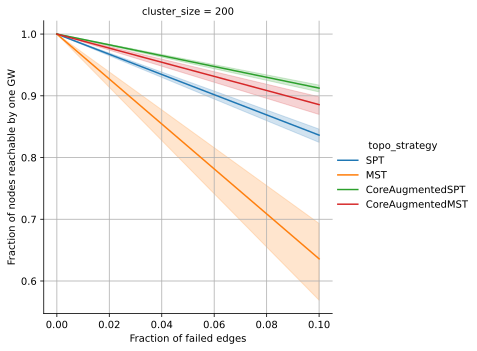

In [7]:

sns.relplot(data=rdf[(rdf.fraction <= 0.1)  ], x='fraction', y='value', hue='topo_strategy', kind='line', col='cluster_size')
plt.grid()
plt.xlabel('Fraction of failed edges')
plt.ylabel('Fraction of nodes reachable by one GW')

**Simple Metrics**

In [11]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

data = []
for (d,f,g,n) in graphs:
    measures = {}
    area, ratio, cluster_size = d.split('_')
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')
    measures['nodes'] = len(g)
    measures['subscriptions'] = n
    measures['edges'] = len(g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(g)
    measures['area'] = area
    measures['ratio'] = ratio
    measures['gateways'] = len([n for n,att in g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in g.nodes() if g.degree()[n]==1])
    measures['relays'] = len([n for n in g.nodes() if g.degree()[n]>=1]) - measures['gateways']
    measures['cluster_size'] = cluster_size
    measures['topo_strategy'] = topo_strategy
    measures['gw_strategy'] = gw_strategy
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
        
df = pd.DataFrame(data)


In [ ]:
sns.catplot(data=df, x='topo_strategy', y='subscriptions', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='relays', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='leaves', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='gateways', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='edges', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='max_pathl', hue='ratio', col='cluster_size', kind='bar')
sns.catplot(data=df, x='topo_strategy', y='avg_pathl', hue='ratio', col='cluster_size', kind='bar')



**CapEx**

In [60]:
import requests 
from pyproj import Proj, transform
inProj = Proj(init='epsg:3003')
outProj = Proj(init='epsg:4326')

def road_distance(c1: tuple[float, float], c2: tuple[float, float]):
   
    vector = np.array(c2)-np.array(c1)
    dist = np.linalg.norm(vector)/1000 #km
    # return dist
    lat1,long1 = transform(inProj,outProj,c1[0],c1[1])
    lat2,long2 = transform(inProj,outProj,c2[0],c2[1])
    query_local = f'http://127.0.0.1:5000/route/v1/driving/{lat1},{long1};{lat2},{long2}?overview=false'
    query_public = f'http://router.project-osrm.org/route/v1/driving/{lat1},{long1};{lat2},{long2}?overview=false'
    r = requests.get(query_local)
    payload = r.json()
    if len(payload['routes']) >1:
        print(payload['routes'])
    road_dist = payload['routes'][0]['distance']/1000
    #print(dist, road_dist, dist/road_dist)
    return road_dist


## FIX MGB for each node
max_bx = 400   #100mbps achievable bw
contention_ratio = 20
mgb =  max_bx/contention_ratio
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, #Imaginary cool router
    'fiber_deploy': 6000, #per km (aerial)
    'relay_router': 250, #
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 250,
    'mp_radio': 200
}
mpant_bw = 120
mchan = 400/contention_ratio
## Calculate shortest path towards closest GW.

fiber_points ={}
fiber_points['pontremoli'] = (1570374.35, 4914132.82)
fiber_points['magliano in toscana'] = (1688243.19, 4718765.36)
fiber_points['sambuca pistoiese'] = (1660029.25, 4885412.44)

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    diff = (beams[1:] - beams[:-1]) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        n_paths *= 2
    d_v = m.ceil(n_paths/mchan)
    return max(phi_v, d_v)

    

def calc_cost_network(g, area):
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws)
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']

    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    fiber_cost = sum([g.nodes[n]['fiber_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return router_cost, fiber_cost, deploy, radio_cost
  

/home/gabriel/.virtualenvs/phigraph2/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/gabriel/.virtualenvs/phigraph2/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [61]:
data = []
data_summed = []
for (d,f,g,n_subs) in graphs:
    graph = g.copy()
    area, ratio, cluster_size = d.split('_')
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')
    costs = calc_cost_network(g, area)
   
    type_costs = ['router_cost', 'fiber_cost', 'deploy', 'radio_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'topo_strategy' : topo_strategy, 
                        'ratio':ratio})

    for i in range(4):
        measures = {}
        measures['cost'] = costs[i]
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size

        measures['topo_strategy'] = topo_strategy
        measures['gw_strategy'] = gw_strategy
        measures['time'] = time
        measures['seed'] = random_seed
        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

/tmp/ipykernel_561748/846864243.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat1,long1 = transform(inProj,outProj,c1[0],c1[1])
/tmp/ipykernel_561748/846864243.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat2,long2 = transform(inProj,outProj,c2[0],c2[1])


In [ ]:
g = sns.catplot(data=sedf, 
            x='topo_strategy',
            y='capex', 
            kind="bar", 
            hue='ratio',
            col='cluster_size',
            row='area')
plt.ylabel("CapEx per customer(€)")
plt.xticks(rotation=45)

**OpEx**

In [31]:
opex_costs = {
    'bw': 21000, #Euros per year for 10gbps  [Cerdà 2020]
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

mttf = {
    'router': 2e5, #hours [verbrugge 2006]
    'radio': 1e5, #hours [random]  5yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours
 }


def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #gbps of minimum gbw
    tengbps = m.ceil(total_bw/10) #number of 10gbps peerings or ports
    fiber = tengbps*opex_costs['bw']
    return fiber

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        

    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return router_maintenance + leafs_maintenance + relays_maintenance
    

In [32]:

data = []
data_summed = []
for (d,f,g,n_subs) in graphs:
    graph = g.copy()
    area, ratio, cluster_size = d.split('_')
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')
    
    fiber_cost = calc_opex_fiber_network(g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(g, 'unplanned_maintenance')

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 #'planned_cost':  planned_maint/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                # 'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                # 'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                'area': area, 
                #'maintennace': 'planned',
                'cluster_size': cluster_size,
                'topo_strategy' : topo_strategy, 
                'ratio':ratio})
    
    

    data_summed.append({'cost': planned_maint+fiber_cost, 
                        'cost_customer': (planned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
                        'cost_customer_monthly': (planned_maint+fiber_cost)/n_subs/12,
                        'area': area, 
                        'maintennace': 'planned',
                        'cluster_size': cluster_size,
                        'topo_strategy' : topo_strategy, 
                        'ratio':ratio})
    
    # data_summed.append({'cost': (unplanned_maint+fiber_cost), 
    #                     'cost_customer': (unplanned_maint+fiber_cost)/n_subs, #Cost per customer per mbps
    #                     'cost_customer_monthly': (unplanned_maint+fiber_cost)/n_subs/12,
    #                     'area': area, 
    #                     'maintennace': 'unplanned',
    #                     'cluster_size': cluster_size,
    #                     'topo_strategy' : topo_strategy, 
    #                     'ratio':ratio})

opdf = pd.DataFrame(data)
sopdf = pd.DataFrame(data_summed)


In [ ]:
g = sns.catplot(data=sopdf, 
            x='topo_strategy',
            y='cost_customer_monthly', 
            kind="bar", 
            hue='ratio')
plt.ylabel("Monthly OpEx per customer(€)")
plt.xticks(rotation=45)

**Offered Bandwidth**

In [78]:
data = []
for (d,f,g,n_subs) in graphs:
    area, ratio, cluster_size = d.split('_')
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    time, random_seed, topo_strategy, gw_strategy = f.split('.')[0].split('_')

    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(g, gws)
    speeds = []
    for src, p in paths.items():
        if src in gws:
            bw = 400
            continue
        else:
            bw = min([400*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p])
        run = {}
        run['area'] = area
        run['cluster_size'] = cluster_size
        run['ratio'] =  ratio
        run['node'] = src
        run['bw'] = bw
        data.append(run)

bwdf = pd.DataFrame(data)

**Gnuplot Graphs**

In [ ]:
opex = opdf[(opdf.ratio!='100')].groupby(['cluster_size', 'topo_strategy']).mean()

def match_maintenance(row):
    if "Augmented" in row.name[1]:
        return row.planned_cost
    else:
        return row.unplanned_cost

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

opex['maintenance'] = opex.apply(match_maintenance, axis=1)
capex = sedf[(sedf.ratio!='100')].groupby(['cluster_size', 'topo_strategy'])['capex'].mean()
data = opex.join(capex)[['maintenance', 'fiber_cost', 'capex']].loc["200"]

to_csv_comment(data.loc[(data.index!="AugmentedMST") & (data.index!="AugmentedMSPT")], '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/costs_200.csv')


# capex = sedf[(sedf.ratio!='200')].groupby(['cluster_size', 'topo_strategy'])['capex'].mean()
# data = opex.join(capex)[['maintenance', 'fiber_cost', 'capex']].loc["100"]

# to_csv_comment(data.loc[(data.index!="AugmentedMST") & (data.index!="AugmentedMSPT")], '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/costs_200.csv')



Fiber deploy over cluster size and customer ratio

In [214]:
fiber = edf[edf.type_cost=='fiber_cost']

data = fiber.groupby(['cluster_size', 'ratio'])['cost_customer'].agg(['mean', ci])
data = data.reset_index().pivot('cluster_size', 'ratio',['mean', 'ci'])
data.columns = ["_".join(a) for a in data.columns.to_flat_index()]

to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/fiber_cost.csv')
data

,mean_100,mean_20,mean_50,ci_100,ci_20,ci_50
cluster_size,,,,,,
100,521.747334,887.765507,648.165378,174.917120,482.793959,176.866936
200,299.591066,222.767936,320.575516,96.220507,35.777647,161.355137
50,848.504160,1647.630051,997.228826,237.835470,610.827881,263.889184


Overall cost for cluster = 200 over customer ratio

In [51]:

costs = opdf[(opdf.cluster_size==200)].groupby('ratio')[['fiber_cost', 'unplanned_cost']].agg(['mean', ci])
capex = sedf[(sedf.cluster_size==200)].groupby('ratio')['capex'].agg(['mean', ci])

costs['capex', 'mean'] = capex['mean']
costs['capex', 'ci'] = capex['ci']
costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]

to_csv_comment(costs, '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/costs.csv')
costs

,fiber_cost_mean,fiber_cost_ci,unplanned_cost_mean,unplanned_cost_ci,capex_mean,capex_ci
ratio,,,,,,
20,8.314479,2.076447,2.750653,0.065097,16.504853,0.870877
50,5.000980,0.276419,2.224863,0.046928,15.513493,2.894701
100,4.490422,0.272208,1.829275,0.039544,13.166334,1.806495


In [62]:

capex = edf[(edf.cluster_size==200)].groupby(['ratio', 'type_cost'])['cost_customer'].agg(['mean', ci])
data =  capex.reset_index().pivot('ratio', 'type_cost',['mean', 'ci'])
data.columns = ["_".join(a) for a in data.columns.to_flat_index()]
to_csv_comment(data, '/home/gabriel/WORKS/TrueNets/PhiGraph/results/processed/capex.csv')
data


,mean_deploy,mean_fiber_cost,mean_radio_cost,mean_router_cost,ci_deploy,ci_fiber_cost,ci_radio_cost,ci_router_cost
ratio,,,,,,,,
20,449.508084,222.767936,244.093778,83.109470,14.333925,35.777647,4.536307,5.875487
50,353.530501,320.575516,203.628632,61.646395,11.349292,161.355137,3.450504,3.784560
100,280.096411,299.591066,174.087312,46.890478,8.306977,96.220507,4.133488,2.449779
